# Tutorial for building own layer in the TensorFlow2
# Made by Daniel Wiczew
# Cotact: daniel.wiczew@gmail.com

In [1]:
# Please download TensorFlow 2.0 or higher to work with the tutorial
!pip uninstall --yes tensorflow
!pip install tensorflow

Uninstalling tensorflow-1.15.0:
  Successfully uninstalled tensorflow-1.15.0
     |████████████████████████████████| 450kB 2.7MB/s 
     |████████████████████████████████| 3.9MB 8.4MB/s 
ERROR: tensorflow-federated 0.12.0 has requirement tensorflow-addons~=0.7.0, but you'll have tensorflow-addons 0.8.3 which is incompatible.
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0


In [0]:
# These are the libraries needed for the tutorial
import tensorflow as tf
from matplotlib.pyplot import imshow
import numpy as np
import pandas as pd

In [2]:
# Make sure that the GPU is available and the version is 2.0 or higher
print(tf.__version__)
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
tf.test.is_gpu_available()  #>>> True

2.1.0
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4521178795135527432
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 4546857645181843592
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 11993612135867426182
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15956161332
locality {
  bus_id: 1
  links {
  }
}
incarnation: 13366759605019209822
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
]
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [0]:
# Download and load CIFAR10 dataset to the memory.
# If you don't have enough memory (which is not the case on the google colab), then you have to download it manually
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [0]:
# Normalize images
x_train = x_train * (1./255.)
x_test = x_test * (1./255.)

# Standarize Images
mean = np.mean(x_train,axis=(0, 1, 2, 3))
std = np.std(x_train,axis=(0, 1, 2, 3))
x_train = (x_train-mean)/(std + 1e-7)
x_test = (x_test-mean)/(std + 1e-7)

# Turn classes to one-hot-encoding matrices
OUTPUT_CLASSES = y_train.max() + 1
y_train = tf.keras.utils.to_categorical(y_train, OUTPUT_CLASSES)
y_test = tf.keras.utils.to_categorical(y_test, OUTPUT_CLASSES)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


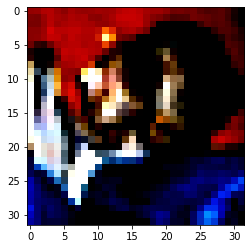

In [5]:
# Example image
imshow(x_test[0])

In [0]:
# Basic constants
# 300 should be enough to train the model
EPOCHS = 300
BATCH_SIZE = 256
INPUT_SHAPE = x_train[255].shape

In [0]:
# Data Augumentation
# You can play with the parameters to get better accuracy
imagegen = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=45, 
                                                           width_shift_range=0.25,
                                                           height_shift_range=0.25,
                                                           horizontal_flip=True,
                                                           zoom_range=0.25,
                                                           shear_range=0.15)
imagegen.fit(x_train)
dataflow = imagegen.flow(x_train, y_train, batch_size=BATCH_SIZE)

In [0]:
# Here is the first resnet layer, that does preserve input shape
# ResNET Layer
class ResidualLayer(tf.keras.layers.Layer):
  def __init__(self, f=None, fillter_size_top=None,
               fillter_size_mid=None, fillter_size_bot=None):
    super(ResidualLayer, self).__init__()
    self.conv_top_1 = tf.keras.layers.Conv2D(fillter_size_top, (1, 1),
                                             strides=(1, 1), padding='valid')
    # Divided by 2 to ensure different parameters
    self.conv_top_2 = tf.keras.layers.Conv2D(fillter_size_top//4, (1, 1),
                                             strides=(1, 1), padding='valid')
    self.conv_mid_1 = tf.keras.layers.Conv2D(fillter_size_mid, (f, f),
                                             strides=(1, 1), padding='same')
    # Divided by 2 to ensure different parameters
    self.conv_mid_2 = tf.keras.layers.Conv2D(fillter_size_mid//4, (f, f),
                                             strides=(1, 1), padding='same')
    self.conv_bot_1 = tf.keras.layers.Conv2D(fillter_size_bot, (1, 1),
                                             strides=(1, 1), padding='valid')
    # The outputs have to be the same to add up
    self.conv_bot_2 = tf.keras.layers.Conv2D(fillter_size_bot, (1, 1),
                                             strides=(1, 1), padding='valid')
    
    self.batch_norm_top_1 = tf.keras.layers.BatchNormalization(axis=3)
    self.batch_norm_top_2 = tf.keras.layers.BatchNormalization(axis=3)
    self.batch_norm_mid_1 = tf.keras.layers.BatchNormalization(axis=3)
    self.batch_norm_mid_2 = tf.keras.layers.BatchNormalization(axis=3)
    self.batch_norm_bot_1 = tf.keras.layers.BatchNormalization(axis=3)
    self.batch_norm_bot_2 = tf.keras.layers.BatchNormalization(axis=3)

    self.activation_relu = tf.keras.layers.Activation('relu')
    self.add_op = tf.keras.layers.Add()

  def call(self, input_x, training=False):
    x_shortcut = input_x

    ##PATH 1
    x_path_1 = input_x
    # First CONV block of path 1
    x_path_1 = self.conv_top_1(x_path_1)
    x_path_1 = self.batch_norm_top_1(x_path_1, training=training)
    x_path_1 = self.activation_relu(x_path_1)

    # Second CONV block of path 1
    x_path_1 = self.conv_mid_1(x_path_1)
    x_path_1 = self.batch_norm_mid_1(x_path_1, training=training)
    x_path_1 = self.activation_relu(x_path_1)

    # Third CONV block of path 1
    x_path_1 = self.conv_bot_1(x_path_1)
    x_path_1 = self.batch_norm_bot_1(x_path_1, training=training)

    ##PATH 2
    x_path_2 = input_x
    # First CONV block of path 1
    x_path_2 = self.conv_top_2(x_path_2)
    x_path_2 = self.batch_norm_top_2(x_path_2, training=training)
    x_path_2 = self.activation_relu(x_path_2)

    # Second CONV block of path 1
    x_path_2 = self.conv_mid_2(x_path_2)
    x_path_2 = self.batch_norm_mid_2(x_path_2, training=training)
    x_path_2 = self.activation_relu(x_path_2)

    # Third CONV block of path 1
    x_path_2 = self.conv_bot_2(x_path_2)
    x_path_2 = self.batch_norm_bot_2(x_path_2, training=training)

    # Addition of PATH 1 and PATH 2
    x = self.add_op([x_path_1, x_path_2])
    # Addition to the shortcut path
    x = self.add_op([x, x_shortcut])
    x_output = self.activation_relu(x)

    return x_output

In [0]:
# Here is the second resnet layer, that does not preserve input shape
# ResNET layer
class ResidualLayerScal(tf.keras.layers.Layer):
  def __init__(self, f=None, s=None, fillter_size_top=None,
               fillter_size_mid=None, fillter_size_bot=None):
    super(ResidualLayerScal, self).__init__()
    self.conv_top_1 = tf.keras.layers.Conv2D(fillter_size_top, (1, 1),
                                             strides=(1, 1), padding='valid')
    # Make the hyperparameters different 
    self.conv_top_2 = tf.keras.layers.Conv2D(fillter_size_top//4, (1, 1),
                                             strides=(1, 1), padding='valid')
    self.conv_mid_1 = tf.keras.layers.Conv2D(fillter_size_mid, (f, f),
                                             strides=(1, 1), padding='same')
    # Make the hyperparameters different 
    self.conv_mid_2 = tf.keras.layers.Conv2D(fillter_size_mid//4, (f, f),
                                             strides=(1, 1), padding='same')
    self.conv_bot_1 = tf.keras.layers.Conv2D(fillter_size_bot, (1, 1),
                                             strides=(s, s), padding='valid')
    # You can't make the hyperparameters different, the output have to be the same
    self.conv_bot_2 = tf.keras.layers.Conv2D(fillter_size_bot, (1, 1),
                                             strides=(s, s), padding='valid')
    self.conv_scal = tf.keras.layers.Conv2D(fillter_size_bot, (1, 1),
                                             strides=(s, s), padding='valid')
    
    self.batch_norm_top_1 = tf.keras.layers.BatchNormalization(axis=3)
    self.batch_norm_top_2 = tf.keras.layers.BatchNormalization(axis=3)
    self.batch_norm_mid_1 = tf.keras.layers.BatchNormalization(axis=3)
    self.batch_norm_mid_2 = tf.keras.layers.BatchNormalization(axis=3)
    self.batch_norm_bot_1 = tf.keras.layers.BatchNormalization(axis=3)
    self.batch_norm_bot_2 = tf.keras.layers.BatchNormalization(axis=3)
    self.batch_norm_scal = tf.keras.layers.BatchNormalization(axis=3)

    self.activation_relu = tf.keras.layers.Activation('relu')
    self.add_op = tf.keras.layers.Add()

  def call(self, input_x, training=False):
    x_shortcut = input_x

    ##PATH 1
    x_path_1 = input_x
    # First CONV block of path 1
    x_path_1 = self.conv_top_1(x_path_1)
    x_path_1 = self.batch_norm_top_1(x_path_1, training=training)
    x_path_1 = self.activation_relu(x_path_1)

    # Second CONV block of path 1
    x_path_1 = self.conv_mid_1(x_path_1)
    x_path_1 = self.batch_norm_mid_1(x_path_1, training=training)
    x_path_1 = self.activation_relu(x_path_1)

    # Third CONV block of path 1
    x_path_1 = self.conv_bot_1(x_path_1)
    x_path_1 = self.batch_norm_bot_1(x_path_1, training=training)

    ##PATH 2
    x_path_2 = input_x
    # First CONV block of path 1
    x_path_2 = self.conv_top_2(x_path_2)
    x_path_2 = self.batch_norm_top_2(x_path_2, training=training)
    x_path_2 = self.activation_relu(x_path_2)

    # Second CONV block of path 1
    x_path_2 = self.conv_mid_2(x_path_2)
    x_path_2 = self.batch_norm_mid_2(x_path_2, training=training)
    x_path_2 = self.activation_relu(x_path_2)

    # Third CONV block of path 1
    x_path_2 = self.conv_bot_2(x_path_2)
    x_path_2 = self.batch_norm_bot_2(x_path_2, training=training)

    # Addition of PATH 1 and PATH 2
    x = self.add_op([x_path_1, x_path_2])
    # Scaling Block
    x_shortcut = self.conv_scal(x_shortcut)
    x_shortcut = self.batch_norm_scal(x_shortcut, training=training)
    # Addition to the shortcut path
    x = self.add_op([x, x_shortcut])
    x_output = self.activation_relu(x)

    return x_output

In [0]:
# Then the layers are combined into a model
class FunnyResNet(tf.keras.Model):
  def __init__(self):
    super(FunnyResNet, self).__init__()
    self.batchnorm_lay1 = tf.keras.layers.BatchNormalization(axis=3)
    self.conv_lay1 = tf.keras.layers.Conv2D(64, strides=(2, 2), kernel_size=(3, 3), activation='relu')
    self.act_lay1 = tf.keras.layers.Activation('relu')


  # Our ResNet block 1
    self.resnet_b1_lay1 = ResidualLayerScal(f=3, s=2, fillter_size_top=128,
                                            fillter_size_mid=128, fillter_size_bot=256)
    self.resnet_b1_lay2 = ResidualLayer(f=3, fillter_size_top=128,
                                        fillter_size_mid=128, fillter_size_bot=256)
    self.resnet_b1_lay3 = ResidualLayer(f=3, fillter_size_top=128,
                                        fillter_size_mid=128, fillter_size_bot=256)
    self.resnet_b1_lay4 = ResidualLayer(f=3, fillter_size_top=128,
                                        fillter_size_mid=128, fillter_size_bot=256)
    self.resnet_b1_lay5 = ResidualLayer(f=3, fillter_size_top=128,
                                        fillter_size_mid=128, fillter_size_bot=256)

    # Our ResNet block 2
    self.resnet_b2_lay1 = ResidualLayerScal(f=5, s=2, fillter_size_top=256,
                                            fillter_size_mid=256, fillter_size_bot=512)
    self.resnet_b2_lay2 = ResidualLayer(f=5, fillter_size_top=256,
                                        fillter_size_mid=256, fillter_size_bot=512)
    self.resnet_b2_lay3 = ResidualLayer(f=5, fillter_size_top=256,
                                        fillter_size_mid=256, fillter_size_bot=512)
    self.resnet_b2_lay4 = ResidualLayer(f=5, fillter_size_top=256,
                                        fillter_size_mid=256, fillter_size_bot=512)
    self.resnet_b2_lay5 = ResidualLayer(f=5, fillter_size_top=256,
                                        fillter_size_mid=256, fillter_size_bot=512)

  # Our ResNet block 3
    self.resnet_b3_lay1 = ResidualLayerScal(f=7, s=2, fillter_size_top=512,
                                            fillter_size_mid=512, fillter_size_bot=1024)
    self.resnet_b3_lay2 = ResidualLayer(f=7, fillter_size_top=512,
                                        fillter_size_mid=512, fillter_size_bot=1024)
    self.resnet_b3_lay3 = ResidualLayer(f=7, fillter_size_top=512,
                                        fillter_size_mid=512, fillter_size_bot=1024)
    self.resnet_b3_lay4 = ResidualLayer(f=7, fillter_size_top=512,
                                        fillter_size_mid=512, fillter_size_bot=1024)
    self.resnet_b3_lay5 = ResidualLayer(f=7, fillter_size_top=512,
                                        fillter_size_mid=512, fillter_size_bot=1024)


    self.flat_lay = tf.keras.layers.Flatten()
    self.dense_lay2 = tf.keras.layers.Dense(OUTPUT_CLASSES, activation='softmax')

  def call(self, x_input, training=False):
    x = self.conv_lay1(x_input)
    x = self.batchnorm_lay1(x, training=training)
    x = self.act_lay1(x)
    # Residual block 1
    x = self.resnet_b1_lay1(x, training=training)
    x = self.resnet_b1_lay2(x, training=training)
    x = self.resnet_b1_lay3(x, training=training)
    x = self.resnet_b1_lay4(x, training=training)
    x = self.resnet_b1_lay5(x, training=training)
    # Residual block 2
    x = self.resnet_b2_lay1(x, training=training)
    x = self.resnet_b2_lay2(x, training=training)
    x = self.resnet_b2_lay3(x, training=training)
    x = self.resnet_b2_lay4(x, training=training)
    x = self.resnet_b2_lay5(x, training=training)
    # Residual block 3
    x = self.resnet_b3_lay1(x, training=training)
    x = self.resnet_b3_lay2(x, training=training)
    x = self.resnet_b3_lay3(x, training=training)
    x = self.resnet_b3_lay4(x, training=training)
    x = self.resnet_b3_lay5(x, training=training)

    x = self.flat_lay(x)
    x = self.dense_lay2(x)
    return x

In [17]:
model = FunnyResNet()
# Set initial weight shapes based on the initial input
model(x_train[0:2])
optimizer = tf.keras.optimizers.Adam(learning_rate=0.02)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



In [0]:
history = model.fit(dataflow, epochs=EPOCHS, shuffle=True,
                    validation_data=[x_test, y_test])

Train for 196 steps, validate on 10000 samples
Epoch 1/300
196/196 [==============================] - 69s 352ms/step - loss: 5.3244 - accuracy: 0.1312 - val_loss: 20.6620 - val_accuracy: 0.1532
Epoch 2/300
196/196 [==============================] - 59s 301ms/step - loss: 2.0875 - accuracy: 0.2100 - val_loss: 2.1129 - val_accuracy: 0.2324
Epoch 3/300
196/196 [==============================] - 59s 301ms/step - loss: 1.9589 - accuracy: 0.2592 - val_loss: 1.8601 - val_accuracy: 0.2832
Epoch 4/300
196/196 [==============================] - 59s 301ms/step - loss: 1.8726 - accuracy: 0.2965 - val_loss: 1.7714 - val_accuracy: 0.3312
Epoch 5/300
196/196 [==============================] - 59s 301ms/step - loss: 1.8119 - accuracy: 0.3248 - val_loss: 1.6825 - val_accuracy: 0.3661
Epoch 6/300
196/196 [==============================] - 59s 301ms/step - loss: 1.7564 - accuracy: 0.3464 - val_loss: 1.6841 - val_accuracy: 0.3654
Epoch 7/300
196/196 [==============================] - 59s 301ms/step - loss